# README
- This file is used to check and drop duplicated entries.

In [1]:
import pandas as pd

In [2]:
data_base_dir = "C:/Users/31155/Dropbox/EV-GasDualNetwork/Data/intermediate/yiwei/intermidiate"

data_GS_dir = f"{data_base_dir}/GS_cleaned"
GS_data_set = {}
for year in range(2013, 2026):
    GS_data_set[year] = pd.read_parquet(f"{data_GS_dir}/GS_data_{year}.parquet")
    print(f"GS data for {year} loaded, Length: {len(GS_data_set[year])}")

data_CS_dir = f"{data_base_dir}/CS_cleaned"
CS_data_set = {}
for year in range(2015, 2026):
    CS_data_set[year] = pd.read_parquet(f"{data_CS_dir}/CS_data_{year}.parquet")
    print(f"CS data for {year} loaded, Length: {len(CS_data_set[year])}")


GS data for 2013 loaded, Length: 101591
GS data for 2014 loaded, Length: 104327
GS data for 2015 loaded, Length: 118011
GS data for 2016 loaded, Length: 119393
GS data for 2017 loaded, Length: 118441
GS data for 2016 loaded, Length: 119393
GS data for 2017 loaded, Length: 118441
GS data for 2018 loaded, Length: 107083
GS data for 2019 loaded, Length: 113338
GS data for 2018 loaded, Length: 107083
GS data for 2019 loaded, Length: 113338
GS data for 2020 loaded, Length: 119894
GS data for 2021 loaded, Length: 121506
GS data for 2020 loaded, Length: 119894
GS data for 2021 loaded, Length: 121506
GS data for 2022 loaded, Length: 110988
GS data for 2023 loaded, Length: 118521
GS data for 2022 loaded, Length: 110988
GS data for 2023 loaded, Length: 118521
GS data for 2024 loaded, Length: 118537
GS data for 2025 loaded, Length: 118315
CS data for 2015 loaded, Length: 1856
CS data for 2016 loaded, Length: 1909
CS data for 2017 loaded, Length: 4252
GS data for 2024 loaded, Length: 118537
GS dat

In [3]:
match_columns = ['pname','cityname','adname','address']

print("==============GS==============")
for key in GS_data_set.keys():
    data_tmp = GS_data_set[key]
    duplicated_rows = data_tmp[data_tmp.duplicated(subset=match_columns, keep=False)]
    duplicate_count = len(duplicated_rows)
    unique_duplicate_groups = data_tmp.duplicated(subset=match_columns, keep='first').sum()
    
    print(f"Year {key}: Total rows: {len(data_tmp)}, Duplicate percentage: {duplicate_count/len(data_tmp)*100:.2f}%")

print("==============CS==============")
for key in CS_data_set.keys():
    data_tmp = CS_data_set[key]
    duplicated_rows = data_tmp[data_tmp.duplicated(subset=match_columns, keep=False)]
    duplicate_count = len(duplicated_rows)
    unique_duplicate_groups = data_tmp.duplicated(subset=match_columns, keep='first').sum()
    
    print(f"Year {key}: Total rows: {len(data_tmp)}, Duplicate percentage: {duplicate_count/len(data_tmp)*100:.2f}%")

==============GS==============
Year 2013: Total rows: 101591, Duplicate percentage: 97.59%
Year 2014: Total rows: 104327, Duplicate percentage: 88.38%
Year 2015: Total rows: 118011, Duplicate percentage: 27.89%
Year 2016: Total rows: 119393, Duplicate percentage: 28.30%
Year 2017: Total rows: 118441, Duplicate percentage: 14.02%
Year 2018: Total rows: 107083, Duplicate percentage: 11.63%
Year 2019: Total rows: 113338, Duplicate percentage: 11.12%
Year 2016: Total rows: 119393, Duplicate percentage: 28.30%
Year 2017: Total rows: 118441, Duplicate percentage: 14.02%
Year 2018: Total rows: 107083, Duplicate percentage: 11.63%
Year 2019: Total rows: 113338, Duplicate percentage: 11.12%
Year 2020: Total rows: 119894, Duplicate percentage: 9.97%
Year 2021: Total rows: 121506, Duplicate percentage: 6.94%
Year 2022: Total rows: 110988, Duplicate percentage: 5.11%
Year 2020: Total rows: 119894, Duplicate percentage: 9.97%
Year 2021: Total rows: 121506, Duplicate percentage: 6.94%
Year 2022: Tot

In [4]:
import sys
sys.path.append("C:/Users/31155/Dropbox/EV-GasDualNetwork/code/yiwei/utils")
from cal_nst_neb_dstn_distribution import calculate_distance_with_xy

In [5]:
calculate_distance_with_xy(100,20,100.01,20.01)

1525.8302668289004

In [6]:
# Compare duplicate rates with and without distance filtering (50m threshold)
def find_duplicates_with_distance(df, match_cols, distance_threshold=50):
    """Find duplicates based on columns and distance threshold"""
    # First find potential duplicates by columns
    potential_duplicates = df[df.duplicated(subset=match_cols, keep=False)]
    
    if len(potential_duplicates) == 0:
        return []
    
    # Group by match columns and check distances within each group
    true_duplicates = []
    for _, group in potential_duplicates.groupby(match_cols):
        if len(group) > 1:
            group_indices = group.index.tolist()
            # Check pairwise distances within the group
            for i in range(len(group_indices)):
                for j in range(i+1, len(group_indices)):
                    idx1, idx2 = group_indices[i], group_indices[j]
                    x1, y1 = df.loc[idx1, 'wgs84_x'], df.loc[idx1, 'wgs84_y']
                    x2, y2 = df.loc[idx2, 'wgs84_x'], df.loc[idx2, 'wgs84_y']

                    # Calculate distance in meters
                    distance = calculate_distance_with_xy(x1, y1, x2, y2)
                    
                    if distance <= distance_threshold:
                        if idx1 not in true_duplicates:
                            true_duplicates.append(idx1)
                        if idx2 not in true_duplicates:
                            true_duplicates.append(idx2)
    
    return true_duplicates


In [7]:
import time
print("==============GS with Distance Filter==============")
for year in GS_data_set.keys():
    data_tmp = GS_data_set[year]
    
    # Original duplicates (column-based only)
    original_duplicates = data_tmp[data_tmp.duplicated(subset=match_columns, keep=False)]
    original_rate = len(original_duplicates) / len(data_tmp) * 100
    
    # Distance-filtered duplicates
    distance_duplicates_idx = find_duplicates_with_distance(data_tmp, match_columns, 50)
    distance_rate = len(distance_duplicates_idx) / len(data_tmp) * 100
    
    print(f"Year {year}: Original: {original_rate:.2f}%, With 50m filter: {distance_rate:.2f}%")
    time.sleep(0.1)  # To avoid overwhelming output

==============GS with Distance Filter==============
Year 2013: Original: 97.59%, With 50m filter: 2.08%
Year 2013: Original: 97.59%, With 50m filter: 2.08%
Year 2014: Original: 88.38%, With 50m filter: 2.73%
Year 2014: Original: 88.38%, With 50m filter: 2.73%
Year 2015: Original: 27.89%, With 50m filter: 5.84%
Year 2015: Original: 27.89%, With 50m filter: 5.84%
Year 2016: Original: 28.30%, With 50m filter: 6.39%
Year 2016: Original: 28.30%, With 50m filter: 6.39%
Year 2017: Original: 14.02%, With 50m filter: 1.06%
Year 2017: Original: 14.02%, With 50m filter: 1.06%
Year 2018: Original: 11.63%, With 50m filter: 1.47%
Year 2018: Original: 11.63%, With 50m filter: 1.47%
Year 2019: Original: 11.12%, With 50m filter: 0.77%
Year 2019: Original: 11.12%, With 50m filter: 0.77%
Year 2020: Original: 9.97%, With 50m filter: 0.40%
Year 2020: Original: 9.97%, With 50m filter: 0.40%
Year 2021: Original: 6.94%, With 50m filter: 0.02%
Year 2021: Original: 6.94%, With 50m filter: 0.02%
Year 2022: Origi

In [10]:
print("==============CS with Distance Filter==============")
for year in CS_data_set.keys():
    data_tmp = CS_data_set[year]
    
    # Original duplicates (column-based only)
    original_duplicates = data_tmp[data_tmp.duplicated(subset=match_columns, keep=False)]
    original_rate = len(original_duplicates) / len(data_tmp) * 100
    
    # Distance-filtered duplicates
    distance_duplicates_idx = find_duplicates_with_distance(data_tmp, match_columns, 50)
    distance_rate = len(distance_duplicates_idx) / len(data_tmp) * 100
    
    print(f"Year {year}: Original: {original_rate:.2f}%, With 50m filter: {distance_rate:.2f}%")
    time.sleep(0.5)

==============CS with Distance Filter==============
Year 2015: Original: 3.23%, With 50m filter: 1.19%
Year 2016: Original: 4.30%, With 50m filter: 2.30%
Year 2016: Original: 4.30%, With 50m filter: 2.30%
Year 2017: Original: 1.72%, With 50m filter: 0.38%
Year 2017: Original: 1.72%, With 50m filter: 0.38%
Year 2018: Original: 1.33%, With 50m filter: 0.35%
Year 2018: Original: 1.33%, With 50m filter: 0.35%
Year 2019: Original: 0.81%, With 50m filter: 0.21%
Year 2019: Original: 0.81%, With 50m filter: 0.21%
Year 2020: Original: 0.62%, With 50m filter: 0.09%
Year 2020: Original: 0.62%, With 50m filter: 0.09%
Year 2021: Original: 0.71%, With 50m filter: 0.01%
Year 2021: Original: 0.71%, With 50m filter: 0.01%
Year 2022: Original: 0.56%, With 50m filter: 0.30%
Year 2022: Original: 0.56%, With 50m filter: 0.30%
Year 2023: Original: 0.45%, With 50m filter: 0.27%
Year 2023: Original: 0.45%, With 50m filter: 0.27%
Year 2024: Original: 1.30%, With 50m filter: 0.87%
Year 2024: Original: 1.30%, Wi

In [11]:
# Save distance-filtered duplicates for inspection
def get_duplicate_groups_with_distance(df, match_cols, distance_threshold=50):
    """Get grouped duplicate data based on columns and distance threshold"""
    potential_duplicates = df[df.duplicated(subset=match_cols, keep=False)]
    
    if len(potential_duplicates) == 0:
        return {}
    
    duplicate_groups = {}
    group_id = 0
    
    for _, group in potential_duplicates.groupby(match_cols):
        if len(group) > 1:
            group_indices = group.index.tolist()
            valid_group = []
            
            # Check pairwise distances within the group
            for i in range(len(group_indices)):
                for j in range(i+1, len(group_indices)):
                    idx1, idx2 = group_indices[i], group_indices[j]
                    x1, y1 = df.loc[idx1, 'wgs84_x'], df.loc[idx1, 'wgs84_y']
                    x2, y2 = df.loc[idx2, 'wgs84_x'], df.loc[idx2, 'wgs84_y']
                    
                    distance = calculate_distance_with_xy(x1, y1, x2, y2)
                    
                    if distance <= distance_threshold:
                        if idx1 not in valid_group:
                            valid_group.append(idx1)
                        if idx2 not in valid_group:
                            valid_group.append(idx2)
            
            if len(valid_group) > 1:
                duplicate_groups[f"group_{group_id}"] = df.loc[valid_group]
                group_id += 1
    
    return duplicate_groups

# Store duplicate groups for GS data
GS_duplicates = {}
for year in GS_data_set.keys():
    GS_duplicates[year] = get_duplicate_groups_with_distance(GS_data_set[year], match_columns, 50)
    print(f"GS {year}: Found {len(GS_duplicates[year])} duplicate groups")

# Store duplicate groups for CS data  
CS_duplicates = {}
for year in CS_data_set.keys():
    CS_duplicates[year] = get_duplicate_groups_with_distance(CS_data_set[year], match_columns, 50)
    print(f"CS {year}: Found {len(CS_duplicates[year])} duplicate groups")

GS 2013: Found 26 duplicate groups
GS 2014: Found 9 duplicate groups
GS 2015: Found 327 duplicate groups
GS 2014: Found 9 duplicate groups
GS 2015: Found 327 duplicate groups
GS 2016: Found 661 duplicate groups
GS 2017: Found 31 duplicate groups
GS 2018: Found 185 duplicate groups
GS 2016: Found 661 duplicate groups
GS 2017: Found 31 duplicate groups
GS 2018: Found 185 duplicate groups
GS 2019: Found 80 duplicate groups
GS 2020: Found 6 duplicate groups
GS 2021: Found 0 duplicate groups
GS 2022: Found 2 duplicate groups
GS 2019: Found 80 duplicate groups
GS 2020: Found 6 duplicate groups
GS 2021: Found 0 duplicate groups
GS 2022: Found 2 duplicate groups
GS 2023: Found 19 duplicate groups
GS 2024: Found 7 duplicate groups
GS 2025: Found 301 duplicate groups
CS 2015: Found 11 duplicate groups
CS 2016: Found 22 duplicate groups
CS 2017: Found 8 duplicate groups
GS 2023: Found 19 duplicate groups
GS 2024: Found 7 duplicate groups
GS 2025: Found 301 duplicate groups
CS 2015: Found 11 dupli

In [17]:
GS_duplicates[2015]['group_4']

,name,address,wgs84_x,wgs84_y,tel,pname,cityname,adname,大类,中类,小类,pname_EN,cityname_EN,corporation
453,中国石油加油站(合欢路),锦绣路1050号,121.548271,31.219107,021-68560995;021-58647205,上海市,上海市,浦东新区,汽车服务,加油站,中国石油,Shanghai,Shanghai,CNPC
71080,中国石油加油站(合欢路),锦绣路1050号,121.548134,31.219265,021-68560995;021-58647205,上海市,上海市,浦东新区,汽车服务,加油站,中国石油,Shanghai,Shanghai,CNPC


In [18]:
sh_2013_gs_data = GS_data_set[2013][GS_data_set[2013]['pname'] == '上海市']
sh_2013_gs_data

,name,address,wgs84_x,wgs84_y,tel,pname,cityname,adname,大类,中类,小类,pname_EN,cityname_EN,corporation
0,九环汽车液化加气站,曹家堰路３８,121.429478,31.215804,,上海市,上海市,长宁区,汽车服务,加气站,加气站,Shanghai,Shanghai,Other
1,强隆加油站,,121.345873,31.225219,,上海市,上海市,长宁区,汽车服务,加油站,中国石化,Shanghai,Shanghai,CPCC
2,中国海油加油站（哈密苑西南）,,121.361647,31.202550,,上海市,上海市,长宁区,汽车服务,加油站,加油站,Shanghai,Shanghai,Other
3,华江石油加油站（万航渡路）,万航渡路５０６,121.430557,31.226794,,上海市,上海市,长宁区,汽车服务,加油站,加油站,Shanghai,Shanghai,Other
4,剑河加油站,泉口路９２号,121.364185,31.209988,,上海市,上海市,长宁区,汽车服务,加油站,中国石化,Shanghai,Shanghai,CPCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934,加油站（堡镇北路）,港沿镇,121.633474,31.564740,,上海市,上海市,崇明区,汽车服务,加油站,中国石油,Shanghai,Shanghai,CNPC
935,中富加油站（惠中）,港沿镇,121.670639,31.614655,,上海市,上海市,崇明区,汽车服务,加油站,中国石化,Shanghai,Shanghai,CPCC
936,加油站,陈家镇乡,121.798172,31.488471,,上海市,上海市,崇明区,汽车服务,加油站,中国石化,Shanghai,Shanghai,CPCC
937,加油站,陈彷公路２５８,121.796645,31.503495,,上海市,上海市,崇明区,汽车服务,加油站,中国石油,Shanghai,Shanghai,CNPC


In [19]:
sh_2014_gs_data = GS_data_set[2014][GS_data_set[2014]['pname'] == '上海市']
sh_2014_gs_data

,name,address,wgs84_x,wgs84_y,tel,pname,cityname,adname,大类,中类,小类,pname_EN,cityname_EN,corporation
6847,中国海油加油站（哈密苑西南）,,121.366265,31.200675,,上海市,上海市,长宁区,汽车服务,加油站,加油站,Shanghai,Shanghai,Other
6848,武夷路加油站,武夷路５６２,121.418685,31.212540,,上海市,上海市,长宁区,汽车服务,加油站,中国石化,Shanghai,Shanghai,CPCC
6849,中国航油加油站（迎宾一路）,迎宾一路３６９,121.351994,31.192082,,上海市,上海市,长宁区,汽车服务,加油站,加油站,Shanghai,Shanghai,Other
6850,中国航油加油站（空港三路）,空港三路１９９,121.350413,31.198119,,上海市,上海市,长宁区,汽车服务,加油站,加油站,Shanghai,Shanghai,Other
6851,华辉加油站,仙霞路１３１０,121.374870,31.207586,,上海市,上海市,长宁区,汽车服务,加油站,中国石油,Shanghai,Shanghai,CNPC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97525,崇明第十三加油站（竖新镇社区文化活动中心东南）,团城公路１８２１,121.584096,31.562553,,上海市,上海市,崇明区,汽车服务,加油站,中国石油,Shanghai,Shanghai,CNPC
97526,金三角加油站（大通路）,堡镇镇,121.616127,31.548102,,上海市,上海市,崇明区,汽车服务,加油站,中国石化,Shanghai,Shanghai,CPCC
97527,崇明第二十加油站,北沿公路３３９８,121.288712,31.817117,,上海市,上海市,崇明区,汽车服务,加油站,中国石油,Shanghai,Shanghai,CNPC
97528,海桥加油站,海桥乡,121.291714,31.789665,,上海市,上海市,崇明区,汽车服务,加油站,中国石化,Shanghai,Shanghai,CPCC


Matched stations between 2013 and 2014: 331
=== Coordinate Difference Statistics ===
X difference - Mean: 0.005330, Std: 0.015370
Y difference - Mean: -0.002438, Std: 0.005236
Distance difference (m) - Mean: 666.97, Std: 1539.83
Max distance difference: 15913.78m
Stations with >50m difference: 331


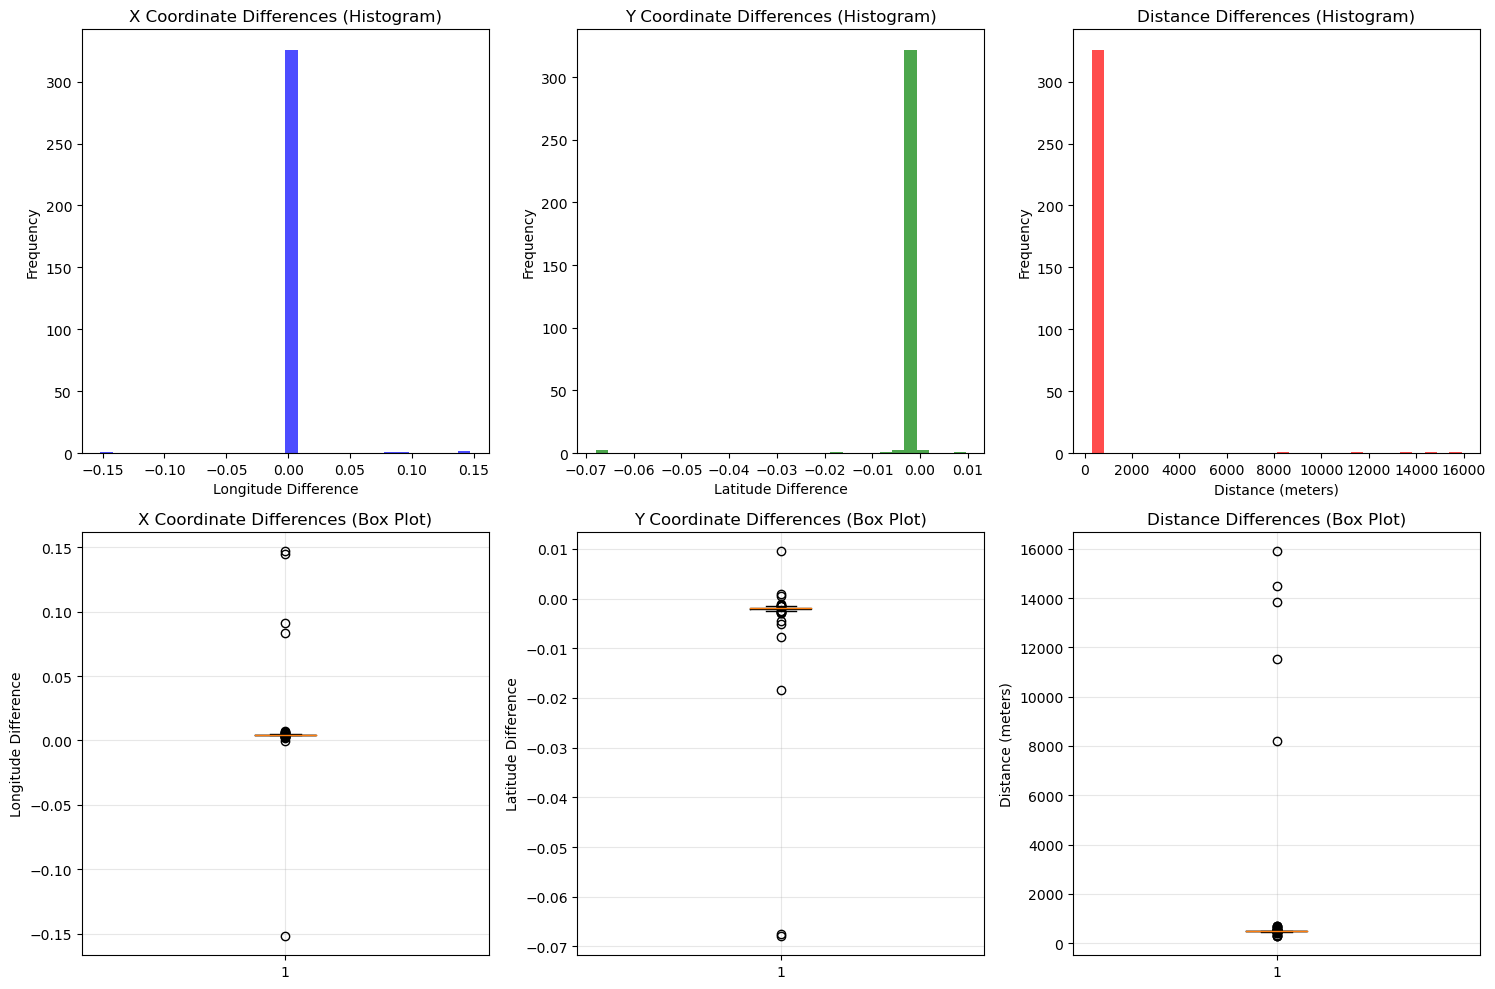


=== Distribution Quantiles ===
X Differences:
  Q1 (25%): 0.004327
  Median (50%): 0.004477
  Q3 (75%): 0.004610
  IQR: 0.000283

Y Differences:
  Q1 (25%): -0.002136
  Median (50%): -0.001991
  Q3 (75%): -0.001889
  IQR: 0.000248

Distance Differences (meters):
  Q1 (25%): 472.96
  Median (50%): 481.33
  Q3 (75%): 486.54
  95th percentile: 512.65
  99th percentile: 10524.71
  IQR: 13.57

Stations with >50m coordinate difference:
              name   address  distance_diff
0        九环汽车液化加气站    曹家堰路３８     486.092536
1   中国海油加油站（哈密苑西南）               486.248965
2        加油站（可乐东路）  哈密路８００－１     486.297284
3         （服务区）加油站               485.238799
4  加油站（双泾寺角落综合小区东）   北翟路１４４２     483.793169


In [21]:
# Analyze coordinate differences between same gas stations in Shanghai 2013 vs 2014
import numpy as np
import matplotlib.pyplot as plt

# Merge data to find matching stations
merged_data = pd.merge(
    sh_2013_gs_data, sh_2014_gs_data, 
    on=match_columns, 
    suffixes=('_2013', '_2014')
)

print(f"Matched stations between 2013 and 2014: {len(merged_data)}")

if len(merged_data) > 0:
    # Calculate coordinate differences
    merged_data['x_diff'] = merged_data['wgs84_x_2014'] - merged_data['wgs84_x_2013']
    merged_data['y_diff'] = merged_data['wgs84_y_2014'] - merged_data['wgs84_y_2013']
    
    # Calculate distance differences in meters
    merged_data['distance_diff'] = merged_data.apply(
        lambda row: calculate_distance_with_xy(
            row['wgs84_x_2013'], row['wgs84_y_2013'],
            row['wgs84_x_2014'], row['wgs84_y_2014']
        ), axis=1
    )
    
    # Statistical analysis
    print("=== Coordinate Difference Statistics ===")
    print(f"X difference - Mean: {merged_data['x_diff'].mean():.6f}, Std: {merged_data['x_diff'].std():.6f}")
    print(f"Y difference - Mean: {merged_data['y_diff'].mean():.6f}, Std: {merged_data['y_diff'].std():.6f}")
    print(f"Distance difference (m) - Mean: {merged_data['distance_diff'].mean():.2f}, Std: {merged_data['distance_diff'].std():.2f}")
    print(f"Max distance difference: {merged_data['distance_diff'].max():.2f}m")
    print(f"Stations with >50m difference: {(merged_data['distance_diff'] > 50).sum()}")
    
    # Distribution analysis with box plots
    plt.figure(figsize=(15, 10))
    
    # Histograms
    plt.subplot(2, 3, 1)
    plt.hist(merged_data['x_diff'], bins=30, alpha=0.7, color='blue')
    plt.title('X Coordinate Differences (Histogram)')
    plt.xlabel('Longitude Difference')
    plt.ylabel('Frequency')
    
    plt.subplot(2, 3, 2)
    plt.hist(merged_data['y_diff'], bins=30, alpha=0.7, color='green')
    plt.title('Y Coordinate Differences (Histogram)')
    plt.xlabel('Latitude Difference')
    plt.ylabel('Frequency')
    
    plt.subplot(2, 3, 3)
    plt.hist(merged_data['distance_diff'], bins=30, alpha=0.7, color='red')
    plt.title('Distance Differences (Histogram)')
    plt.xlabel('Distance (meters)')
    plt.ylabel('Frequency')
    
    # Box plots to show distribution and outliers
    plt.subplot(2, 3, 4)
    plt.boxplot(merged_data['x_diff'], vert=True)
    plt.title('X Coordinate Differences (Box Plot)')
    plt.ylabel('Longitude Difference')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, 5)
    plt.boxplot(merged_data['y_diff'], vert=True)
    plt.title('Y Coordinate Differences (Box Plot)')
    plt.ylabel('Latitude Difference')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, 6)
    plt.boxplot(merged_data['distance_diff'], vert=True)
    plt.title('Distance Differences (Box Plot)')
    plt.ylabel('Distance (meters)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print quantile information for better understanding of distribution
    print("\n=== Distribution Quantiles ===")
    print("X Differences:")
    print(f"  Q1 (25%): {merged_data['x_diff'].quantile(0.25):.6f}")
    print(f"  Median (50%): {merged_data['x_diff'].quantile(0.5):.6f}")
    print(f"  Q3 (75%): {merged_data['x_diff'].quantile(0.75):.6f}")
    print(f"  IQR: {merged_data['x_diff'].quantile(0.75) - merged_data['x_diff'].quantile(0.25):.6f}")
    
    print("\nY Differences:")
    print(f"  Q1 (25%): {merged_data['y_diff'].quantile(0.25):.6f}")
    print(f"  Median (50%): {merged_data['y_diff'].quantile(0.5):.6f}")
    print(f"  Q3 (75%): {merged_data['y_diff'].quantile(0.75):.6f}")
    print(f"  IQR: {merged_data['y_diff'].quantile(0.75) - merged_data['y_diff'].quantile(0.25):.6f}")
    
    print("\nDistance Differences (meters):")
    print(f"  Q1 (25%): {merged_data['distance_diff'].quantile(0.25):.2f}")
    print(f"  Median (50%): {merged_data['distance_diff'].quantile(0.5):.2f}")
    print(f"  Q3 (75%): {merged_data['distance_diff'].quantile(0.75):.2f}")
    print(f"  95th percentile: {merged_data['distance_diff'].quantile(0.95):.2f}")
    print(f"  99th percentile: {merged_data['distance_diff'].quantile(0.99):.2f}")
    print(f"  IQR: {merged_data['distance_diff'].quantile(0.75) - merged_data['distance_diff'].quantile(0.25):.2f}")
    
    # Show stations with large coordinate differences
    large_diff = merged_data[merged_data['distance_diff'] > 50]
    if len(large_diff) > 0:
        print(f"\nStations with >50m coordinate difference:")
        print(large_diff[['name', 'address', 'distance_diff']].head())
else:
    print("No matching stations found between 2013 and 2014")